In [1]:
# Imports 
import os
import re, string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier
from tqdm.auto import tqdm
tqdm.pandas()
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# configuration 
SEED        = 42        
SUB_FRAC    = 0.05      # work on 5 % of the merged dataset
MAX_WORDS   = 10_000    # vocab size for Keras Tokenizer
EMBED_DIM   = 64        # embedding dimension for LSTM
BATCH_SIZE  = 128       # per‑epoch batch size
EPOCHS      = 10        # upper epoch bound 
PATIENCE    = 2         # early‑stopping patience

np.random.seed(SEED)
keras.utils.set_random_seed(SEED)


C:\Users\ymona\anaconda3\envs\nlp_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load & Merge Data
books_data   = pd.read_csv("books_data.csv")
books_rating = pd.read_csv("books_rating.csv")

df = pd.merge(books_rating, books_data, on="Title", how="inner")
df.shape

(3000000, 19)

In [3]:
df.head(3)

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],NaN
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t...",Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 19 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  object 
 1   Title               object 
 2   Price               float64
 3   User_id             object 
 4   profileName         object 
 5   review/helpfulness  object 
 6   review/score        float64
 7   review/time         int64  
 8   review/summary      object 
 9   review/text         object 
 10  description         object 
 11  authors             object 
 12  image               object 
 13  previewLink         object 
 14  publisher           object 
 15  publishedDate       object 
 16  infoLink            object 
 17  categories          object 
 18  ratingsCount        float64
dtypes: float64(3), int64(1), object(15)
memory usage: 434.9+ MB


In [5]:
# Total dataset size on disk (GB) 
file_paths = ["books_rating.csv", "books_data.csv"]  
total_size_bytes = sum(os.path.getsize(fp) for fp in file_paths)
total_size_gb = total_size_bytes / (1024 ** 3)
print(f"Total dataset size on disk: {total_size_gb:.2f} GB")


Total dataset size on disk: 2.83 GB


In [6]:
# List the names of CSV files
file1 = "books_rating.csv"
file2 = "books_data.csv"

# Get the file sizes in bytes and add them up
size1 = os.path.getsize(file1)
size2 = os.path.getsize(file2)
total_bytes = size1 + size2

# Convert bytes to gigabytes (1 GB = 1024^3 bytes)
total_gb = total_bytes / (1024 ** 3)

# Show the result
print(f"Total dataset size on disk: {total_gb:.2f} GB")

Total dataset size on disk: 2.83 GB


In [7]:
# Convert timestamp to datetime 
df["review/time"] = pd.to_datetime(df["review/time"], unit="s", errors="coerce")
# unit="s" means the numbers are Unix timestamps in seconds
# errors="coerce"  turns invalid values into NaT so the code keeps running.

In [8]:
review_times = df["review/time"]
review_times

0         1999-10-23
1         2004-09-21
2         2004-03-09
3         2004-07-25
4         2005-02-10
             ...    
2999995   1999-09-18
2999996   2012-03-14
2999997   2007-05-27
2999998   2006-11-09
2999999   1998-09-10
Name: review/time, Length: 3000000, dtype: datetime64[ns]

In [9]:
df["review_year"]    = df["review/time"].dt.year.astype(int)
df["review_month"]   = df["review/time"].dt.month.astype(int)
df["review_weekday"] = df["review/time"].dt.weekday.astype(int)


In [10]:
earliest = review_times.min()
earliest


Timestamp('1969-12-31 23:59:59')

In [11]:
latest = review_times.max()
latest


Timestamp('2013-03-04 00:00:00')

In [12]:
start_date = earliest.date()
end_date = latest.date()
start_date, end_date


(datetime.date(1969, 12, 31), datetime.date(2013, 3, 4))

In [13]:
# Percentage of object, float, and int columns

dtype_pct = (
    df.dtypes.value_counts(normalize=True).sort_index() * 100
).round(2)
for dtype, pct in dtype_pct.items():
    print(f"  {dtype}: {pct}%")

  int32: 13.64%
  float64: 13.64%
  datetime64[ns]: 4.55%
  object: 68.18%


In [14]:
# Get numeric summary statistics
numeric_summary = df.describe()

print(numeric_summary)


               Price  review/score                    review/time  \
count  481171.000000  3.000000e+06                        3000000   
mean       21.762656  4.215289e+00  2005-11-18 09:39:32.630393216   
min         1.000000  1.000000e+00            1969-12-31 23:59:59   
25%        10.780000  4.000000e+00            2001-09-08 00:00:00   
50%        14.930000  5.000000e+00            2005-10-03 00:00:00   
75%        23.950000  5.000000e+00            2010-03-21 00:00:00   
max       995.000000  5.000000e+00            2013-03-04 00:00:00   
std        26.206541  1.203054e+00                            NaN   

       ratingsCount   review_year  review_month  review_weekday  
count  1.639306e+06  3.000000e+06  3.000000e+06    3.000000e+06  
mean   2.720647e+02  2.005400e+03  6.309873e+00    2.849597e+00  
min    1.000000e+00  1.969000e+03  1.000000e+00    0.000000e+00  
25%    3.000000e+00  2.001000e+03  3.000000e+00    1.000000e+00  
50%    1.000000e+01  2.005000e+03  6.000000e+00 

In [15]:
# Show % null value in each column:
round(df.isnull().sum() / df.shape[0] * 100.00,2)

Id                     0.00
Title                  0.01
Price                 83.96
User_id               18.73
profileName           18.73
review/helpfulness     0.00
review/score           0.00
review/time            0.00
review/summary         0.01
review/text            0.00
description           21.34
authors               13.02
image                 18.01
previewLink           11.02
publisher             26.09
publishedDate         11.82
infoLink              11.02
categories            18.38
ratingsCount          45.36
review_year            0.00
review_month           0.00
review_weekday         0.00
dtype: float64

In [16]:
# List of columns to drop
cols_to_drop = [
    "Id",                      # Unique identifier, useless for sentiment
    "Price",                   # Over 80 % missing
    "User_id",                 # just an id - no predictive value
    "profileName",             # profile name - no predictive value
    "image",                   # Just a URL to the book cover - no predictive value
    "previewLink",             # preview links is not  relevant at predicting sentiment
    "publishedDate",           # keep pub_year instead
    "infoLink"                 # Like previewLink - no predictive value
]

# Drop 
df.drop(columns=cols_to_drop, inplace=True)

In [17]:
# check to see columns were dropped:
round(df.isnull().sum() / df.shape[0] * 100.00,2)

Title                  0.01
review/helpfulness     0.00
review/score           0.00
review/time            0.00
review/summary         0.01
review/text            0.00
description           21.34
authors               13.02
publisher             26.09
categories            18.38
ratingsCount          45.36
review_year            0.00
review_month           0.00
review_weekday         0.00
dtype: float64

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 14 columns):
 #   Column              Dtype         
---  ------              -----         
 0   Title               object        
 1   review/helpfulness  object        
 2   review/score        float64       
 3   review/time         datetime64[ns]
 4   review/summary      object        
 5   review/text         object        
 6   description         object        
 7   authors             object        
 8   publisher           object        
 9   categories          object        
 10  ratingsCount        float64       
 11  review_year         int32         
 12  review_month        int32         
 13  review_weekday      int32         
dtypes: datetime64[ns](1), float64(2), int32(3), object(8)
memory usage: 286.1+ MB


In [19]:
# List of columns to inspect
cols = [
    "Title",
    "review/helpfulness",
    "review/score",
    "review/time",
    "review/summary",
    "review/text",
    "description",
    "authors",
    "publisher",
    "categories",
    "ratingsCount"
]

# Compute and display the number of unique values 
total_rows = len(df)
for col in cols:
    unique_count = df[col].nunique(dropna=True)
    print(f"{col:20s}: {unique_count:7d} ")



Title               :  212403 
review/helpfulness  :   12084 
review/score        :       5 
review/time         :    6272 
review/summary      : 1592314 
review/text         : 2062648 
description         :  133226 
authors             :  127278 
publisher           :   16016 
categories          :   10883 
ratingsCount        :     478 


In [20]:
# Star-rating distribution
star_counts = df["review/score"].value_counts()
star_counts


review/score
5.0    1807343
4.0     585616
3.0     254295
1.0     201688
2.0     151058
Name: count, dtype: int64

In [21]:
star_percentages = df["review/score"].value_counts(normalize=True) * 100
star_percentages


review/score
5.0    60.244767
4.0    19.520533
3.0     8.476500
1.0     6.722933
2.0     5.035267
Name: proportion, dtype: float64

In [22]:
star_percentages = star_percentages.sort_index()
star_percentages


review/score
1.0     6.722933
2.0     5.035267
3.0     8.476500
4.0    19.520533
5.0    60.244767
Name: proportion, dtype: float64

In [23]:
star_percentages = star_percentages.round(2)
star_percentages


review/score
1.0     6.72
2.0     5.04
3.0     8.48
4.0    19.52
5.0    60.24
Name: proportion, dtype: float64

In [24]:
# Replace missing values with "" in text fields so tokenizer skips them
for col in ["Title", "review/summary", "description"]:
    df[col].fillna("", inplace=True)                      

# Replace missing number of ratings with 0
df["ratingsCount"].fillna(0, inplace=True)      

# Replace missing author names, publishers & categories with "Unknown"
df["authors"].fillna("Unknown", inplace=True)           
df["publisher"].fillna("Unknown", inplace=True)         
df["categories"].fillna("categories", inplace=True)         

C:\Users\ymona\AppData\Local\Temp\ipykernel_4636\3788879693.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna("", inplace=True)
C:\Users\ymona\AppData\Local\Temp\ipykernel_4636\3788879693.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing '

In [25]:
# Split "review/helpfulness" like "3/5" into two separate columns
help_df = df["review/helpfulness"].str.split("/", expand=True)

# Convert both columns to float numbers
help_df = help_df.astype(float)


In [26]:
# Divide helpful votes (numerator) by total votes (denominator)
df["help_ratio"] = help_df[0] / help_df[1]


In [27]:
# Replace any NaN (from 0/0 or missing data) with 0
df["help_ratio"] = df["help_ratio"].fillna(0)


In [28]:
# drop the original "review/helpfulness" column
df.drop(columns=["review/helpfulness"], inplace=True)

In [29]:
# Check for missing values (%), ensure 'help_ratio' has no NaNs, and confirm 'review/helpfulness' was dropped
round(df.isnull().sum() / df.shape[0] * 100.00,2)

Title             0.0
review/score      0.0
review/time       0.0
review/summary    0.0
review/text       0.0
description       0.0
authors           0.0
publisher         0.0
categories        0.0
ratingsCount      0.0
review_year       0.0
review_month      0.0
review_weekday    0.0
help_ratio        0.0
dtype: float64

In [30]:
# Authors bucketing — keep only the top 100 authors, group all others as “Other”
TOP_N = 100


In [31]:
# Count how often each author appears and keep the top 100
top_authors = df["authors"].value_counts().nlargest(TOP_N)


In [32]:
# If the author is in the top 100, keep it; otherwise set as "Other"
df["authors_bucketed"] = df["authors"].where(df["authors"].isin(top_authors.index), "Other")


In [33]:
# There should be 101 buckets: 100 top authors + 1 "Other"
print(df["authors_bucketed"].nunique(), "unique author buckets")


101 unique author buckets


In [34]:
# Categories bucketing — keep only the top 100 categories, group all others as “Other”
TOP_N_CATEGORIES = 100


In [35]:
# Count how often each category appears and keep the top 100
top_categories = df["categories"].value_counts().nlargest(TOP_N_CATEGORIES)


In [36]:
# If the category is in the top 100, keep it; otherwise set as "Other"
df["categories_bucketed"] = df["categories"].where(df["categories"].isin(top_categories.index), "Other")


In [37]:
# There should be 101 buckets: 100 top categories + 1 "Other"
print(df["categories_bucketed"].nunique(), "unique category buckets")


101 unique category buckets


In [38]:
df.head()

,Title,review/score,review/time,review/summary,review/text,description,authors,publisher,categories,ratingsCount,review_year,review_month,review_weekday,help_ratio,authors_bucketed,categories_bucketed
0,Its Only Art If Its Well Hung!,4.0,1999-10-23,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...,,['Julie Strain'],Unknown,['Comics & Graphic Novels'],0.0,1999,10,5,1.000000,Other,['Comics & Graphic Novels']
1,Dr. Seuss: American Icon,5.0,2004-09-21,Really Enjoyed It,I don't care much for Dr. Seuss but after read...,Philip Nel takes a fascinating look into the k...,['Philip Nel'],A&C Black,['Biography & Autobiography'],0.0,2004,9,1,1.000000,Other,['Biography & Autobiography']
2,Dr. Seuss: American Icon,5.0,2004-03-09,Essential for every personal and Public Library,"If people become the books they read and if ""t...",Philip Nel takes a fascinating look into the k...,['Philip Nel'],A&C Black,['Biography & Autobiography'],0.0,2004,3,1,0.909091,Other,['Biography & Autobiography']
3,Dr. Seuss: American Icon,4.0,2004-07-25,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",Philip Nel takes a fascinating look into the k...,['Philip Nel'],A&C Black,['Biography & Autobiography'],0.0,2004,7,6,1.000000,Other,['Biography & Autobiography']
4,Dr. Seuss: American Icon,4.0,2005-02-10,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...,Philip Nel takes a fascinating look into the k...,['Philip Nel'],A&C Black,['Biography & Autobiography'],0.0,2005,2,3,1.000000,Other,['Biography & Autobiography']


In [39]:
# Subsampling strategy for fast iteration

df_s = df.sample(frac=SUB_FRAC, random_state=SEED).reset_index(drop=True)
print(f"Subsample shape: {df_s.shape}\n")

Subsample shape: (150000, 16)



In [40]:
# Create binary sentiment: 0 for ≤2-star, 1 for ≥4-star, drop 3-star neutrals 
df_s["sentiment"] = np.select(
    [df_s["review/score"] <= 2, df_s["review/score"] >= 4],
    [0, 1],
    default=np.nan
)
# Save initial number of rows to compare later
initial_rows = len(df_s)

# Drop rows where sentiment is NaN (the 3-star reviews)
df_s.dropna(subset=["sentiment"], inplace=True)

# Convert sentiment values from float to int 
df_s["sentiment"] = df_s["sentiment"].astype(int)
print(f"Dropped neutrals: {initial_rows - len(df_s)} rows — remaining: {len(df_s)}")

Dropped neutrals: 12656 rows — remaining: 137344


In [41]:
# Show sentiment class distribution in %
sentiment_pct = (df_s["sentiment"].value_counts(normalize=True) * 100).round(2)
sentiment_pct


sentiment
1    87.16
0    12.84
Name: proportion, dtype: float64

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 16 columns):
 #   Column               Dtype         
---  ------               -----         
 0   Title                object        
 1   review/score         float64       
 2   review/time          datetime64[ns]
 3   review/summary       object        
 4   review/text          object        
 5   description          object        
 6   authors              object        
 7   publisher            object        
 8   categories           object        
 9   ratingsCount         float64       
 10  review_year          int32         
 11  review_month         int32         
 12  review_weekday       int32         
 13  help_ratio           float64       
 14  authors_bucketed     object        
 15  categories_bucketed  object        
dtypes: datetime64[ns](1), float64(3), int32(3), object(9)
memory usage: 331.9+ MB


In [43]:
# Text preprocessing & tokenization 

# Merge all text fields into one
df_s["raw_text"] = (
    df_s["review/text"].fillna("") + " " +
    df_s["review/summary"].fillna("") + " " +
    df_s["description"].fillna("") + " " +
    df_s["Title"].fillna("")
)     


# Load English NLP model from spacy
_nlp = spacy.load("en_core_web_sm")

# clean raw text to string

# Define a text cleaning function
def clean_text(text: str) -> str:
    text = str(text).lower()
    text = re.sub(r"https?://\S+|www\.\S+", "", text)                 # remove URLs
    text = text.translate(str.maketrans("", "", string.punctuation))  # remove punctuation
    text = re.sub(r"\d+", "", text)                                  # remove digits
    return re.sub(r"\s+", " ", text).strip()                         # clean up whitespace

# define a tokenization + lemmatization function

def spacy_tokens(doc: str):
    doc = _nlp(doc)
    return [
        tok.lemma_.lower()              # reduces words to their base forms 
        for tok in doc
        if tok.is_alpha                # Keeps only alphabetic words 
        and not tok.is_stop            # Removes stopwords 
        and len(tok) > 1               # Keeps only words with more than 1 character
    ]
    
# Apply text cleaning to raw_text column
df_s["clean_text"] = df_s["raw_text"].progress_apply(clean_text)  

# Apply tokenization and lemmatization to the cleaned text
df_s["tokens"]     = df_s["clean_text"].progress_apply(spacy_tokens)  



100%|██████████| 137344/137344 [1:15:12<00:00, 30.44it/s]


In [44]:
# train-test split 
train_idx, test_idx = train_test_split(
    df_s.index,
    stratify=df_s["sentiment"], # ensures class balance in both sets
    test_size=0.2,
    random_state=SEED   # ensures reproducibility
)

train_df = df_s.loc[train_idx].reset_index(drop=True)
test_df  = df_s.loc[test_idx].reset_index(drop=True)
print(f"Train rows: {len(train_df)} | Test rows: {len(test_df)}")

Train rows: 109875 | Test rows: 27469


In [45]:
# LSTM model on all text columns combined
# Merge tokens into text strings
train_texts = train_df["tokens"].str.join(" ")    # all_tokens = review+summary+description+Title
test_texts  = test_df["tokens"].str.join(" ")

# Initialize tokenizer
_tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
_tokenizer.fit_on_texts(train_texts)

# Convert text to sequences of word indices
seq_train = _tokenizer.texts_to_sequences(train_texts)
seq_test  = _tokenizer.texts_to_sequences(test_texts)

# cover 95 % token count in train set
maxlen = int(pd.Series([len(s) for s in seq_train]).quantile(0.95))
print(f"Chosen sequence length: {maxlen}")


# Pad sequences to fixed length
X_train_text = pad_sequences(seq_train, maxlen=maxlen, padding="post", truncating="post")
X_test_text  = pad_sequences(seq_test,  maxlen=maxlen, padding="post", truncating="post")

# Extract target labels
y_train = train_df["sentiment"].values
y_test  = test_df["sentiment"].values

# Define Bi-LSTM model
print("Building Bi-LSTM …")
model = keras.Sequential([
    layers.Embedding(MAX_WORDS, EMBED_DIM, input_length=maxlen), # word embeddings
    layers.Bidirectional(layers.LSTM(64)),    # Bi-LSTM layer
    layers.Dense(32, activation="relu"),        # dense hidden layer
    layers.Dense(1,  activation="sigmoid")      # binary output
])

# Compile model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


# Set early stopping
callbacks = [keras.callbacks.EarlyStopping(patience=PATIENCE, restore_best_weights=True)]


# Train model
history = model.fit(
    X_train_text, y_train,
    validation_split=0.1,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=2
)

# Evaluate on test set
loss, acc = model.evaluate(X_test_text, y_test, verbose=0)
print(f"Bi-LSTM test accuracy: {acc:.3f}\n")



Chosen sequence length: 292
Building Bi-LSTM …
Epoch 1/10
773/773 - 347s - loss: 0.2554 - accuracy: 0.9051 - val_loss: 0.2080 - val_accuracy: 0.9225 - 347s/epoch - 449ms/step
Epoch 2/10
773/773 - 601s - loss: 0.1846 - accuracy: 0.9316 - val_loss: 0.2142 - val_accuracy: 0.9200 - 601s/epoch - 778ms/step
Epoch 3/10
773/773 - 509s - loss: 0.1588 - accuracy: 0.9421 - val_loss: 0.2130 - val_accuracy: 0.9226 - 509s/epoch - 659ms/step
Bi-LSTM test accuracy: 0.919



So after cleaning and preparing the data, I trained a Bi-LSTM model on the full set of combined text fields review, summary, description, and title.  The model trained for 3 epochs before early stopping kicked in. It started at around 90% accuracy and improved steadily, ending with a final test accuracy of about 92%. That shows the model is learning well and generalizing effectively to new, unseen reviews.

In [47]:
# Get predicted labels 
y_pred_proba = model.predict(X_test_text, verbose=0)
y_pred = (y_pred_proba >= 0.5).astype(int).reshape(-1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix (rows=true, cols=predicted):\n", cm)

# Precision, recall, f1 for each class
print("\nClassification report:\n", classification_report(y_test, y_pred, target_names=["negative","positive"]))

Confusion matrix (rows=true, cols=predicted):
 [[ 1970  1556]
 [  669 23274]]

Classification report:
               precision    recall  f1-score   support

    negative       0.75      0.56      0.64      3526
    positive       0.94      0.97      0.95     23943

    accuracy                           0.92     27469
   macro avg       0.84      0.77      0.80     27469
weighted avg       0.91      0.92      0.91     27469



Overall accuracy is 92%. The model recognizes positive reviews well (precision 0.94, recall 0.97). The negative class is weaker: recall is 0.56, with 1,556 negatives predicted as positive. Because positives are the majority, the weighted scores stay high. 

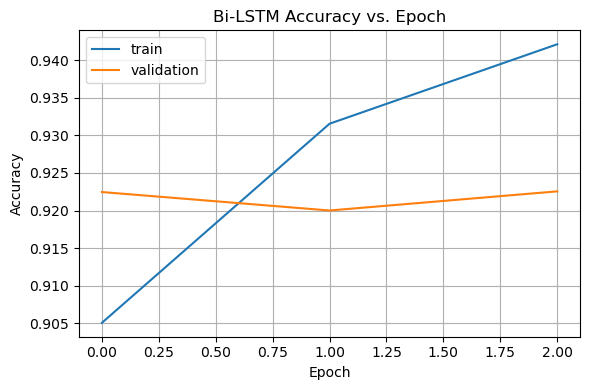

In [48]:
# Evaluation & visualisation 
plt.figure(figsize=(6,4))
plt.plot(history.history["accuracy"],     label="train")
plt.plot(history.history["val_accuracy"], label="validation")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Bi-LSTM Accuracy vs. Epoch")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

The chart shows training accuracy climbing each epoch (about 0.905 → 0.945), while validation accuracy stays roughly flat around 0.92–0.923.  Early stopping kicked in after 3 epochs because validation stopped improving, so more epochs likely wouldn’t help. Overall, the model learns quickly and stabilizes.

In [49]:
# Export trained Bi-LSTM from the notebook

In [113]:
from tensorflow import keras
import os, json

# Choose the folder where you want to store the saved (model/tokenizer/maxlen)
SAVE_DIR = r"C:\Users\ymona\Documents\final_milestone_1014"

# Create the folder
os.makedirs(SAVE_DIR, exist_ok=True)

# Build the full path for the model file (bilstm.keras) inside SAVE_DIR
model_path = os.path.join(SAVE_DIR, "bilstm.keras")

# Save the trained Keras model in .keras format
model.save(model_path)

#  Save tokenizer.json
TOKENIZER_PATH = os.path.join(SAVE_DIR, "tokenizer.json")

with open(TOKENIZER_PATH, "w", encoding="utf-8") as f:
    f.write(_tokenizer.to_json())

# Save maxlen.txt
MAXLEN_PATH = os.path.join(SAVE_DIR, "maxlen.txt")

with open(MAXLEN_PATH, "w", encoding="utf-8") as f:
    f.write(str(int(maxlen)))

The file `bilstm.keras` is the actual trained  Bi-LSTM’s architecture and learned weights.

The file `tokenizer.json` is the dictionary the model learned from. 

Finally, `maxlen.txt` is the sequence length it padded/truncated to; using the same length at prediction time keeps inputs in the shape the model expects. 

In [ ]:
## Save model card (governance & reproducibility)

In [116]:
import  datetime, platform

# Open a file called "model_card.json" in SAVE_DIR for writing as UTF-8 text
with open(os.path.join(SAVE_DIR, "model_card.json"), "w", encoding="utf-8") as f:
    # Write a Python dict into the file
    json.dump({
        #  name for trained model
        "model_name": "BiLSTM_book_sentiment",

        # When this card was created 
        "created": str(datetime.datetime.now()),

        # Exact Python version for reproducibility
        "python": platform.python_version(),

        # ML framework used
        "framework": "tensorflow.keras",

        # Number of training samples used
        "train_samples": int(len(y_train)),

        # Number of test samples  used
        "test_samples": int(len(y_test)),

        # Your test accuracy 
        "test_accuracy": float(acc),  

        # What the model is intended to be used for
        "intended_use": "Classify book review sentiment (binary).",

        # Cases the model is NOT designed to handle
        "out_of_scope": ["non-English text without retraining", "sarcasm/irony"],

        # Known weaknesses 
        "known_limitations": [
            "Class imbalance (more positive than negative)",
            "Threshold 0.5 may not be optimal",
            "Performance depends on text length/vocabulary"
        ],

        #  steps  to reduce risk
        "risk_mitigation": [
            "Use class_weight or resampling",
            "Keep validation split + early stopping",
            "Retrain if data distribution shifts"
        ],

        # Pointers to the saved 
        "artifacts": {
            "model": "bilstm.keras",
            "tokenizer": "tokenizer.json",
            "maxlen": "maxlen.txt"
        }
    }, f, indent=2)

# Confirm where the model card was written
print("Wrote:", os.path.join(SAVE_DIR, "model_card.json"))


Wrote: C:\Users\ymona\Documents\final_milestone_1014\model_card.json


Here we create a small “model card”  that documents the trained model and its context. It records the model name, creation time, software versions, train/test sizes, test accuracy, intended use and out-of-scope cases, known limitations, basic risk-mitigation notes, and the exact artifact files (`bilstm.keras`, `tokenizer.json`, `maxlen.txt`). In practice, it acts like a receipt and safety label for the model so anyone reading the project later can quickly understand what was built, how it performed, and how it should be used. This improves traceability, reproducibility, and governance, and fits well into the final report’s documentation requirements.


In [118]:
# Load trained from SAVE_DIR 
# Load the trained Keras model from disk
model2 = keras.models.load_model(os.path.join(SAVE_DIR, "bilstm.keras"))

# Load the fitted tokenizer from JSON (read file as text, then rebuild tokenizer)
with open(os.path.join(SAVE_DIR, "tokenizer.json"), "r", encoding="utf-8") as f:
    tok2 = tokenizer_from_json(f.read())

# Load the exact sequence length used during training (needed for padding at inference)
with open(os.path.join(SAVE_DIR, "maxlen.txt"), "r", encoding="utf-8") as f:
    MAXLEN = int(f.read().strip())


Now we reload everything needed to make consistent predictions after training. First, the trained Bi-LSTM network is loaded from `bilstm.keras` (its architecture and learned weights). Next, the fitted tokenizer is reconstructed from `tokenizer.json`, which restores the exact word-to-index mapping created during training. Finally, the padding length is read from `maxlen.txt`, so input text is padded/truncated to the same size as before. With the model, tokenizer, and maxlen back in memory, inference will behave exactly like it did at training time, reproducible and consistent.


In [130]:
# single-text predictor

def predict_text(txt: str):
    # Guard against empty/whitespace input
    if not isinstance(txt, str) or not txt.strip():
        return {"error": "empty_text", "label": None, "confidence": 0.0}

    # Convert text -> integer sequence using the same tokenizer as training
    seq = tok2.texts_to_sequences([txt])

    # Pad/truncate to the exact MAXLEN used during training
    x = pad_sequences(seq, maxlen=MAXLEN, padding="post", truncating="post")

    # Get probability from the model (value in [0, 1])
    p = float(model2.predict(x, verbose=0)[0][0])

    # Map probability to label + confidence
    label = "positive" if p >= 0.5 else "negative"
    conf  = round(p if p >= 0.5 else 1 - p, 3)

    return {"label": label, "confidence": conf}


This function is a predictor for a single piece of text. It first checks for empty or whitespace and returns a clear error in that case. 

For valid text, it uses the same tokenizer from training to turn the words into integer indices, then pads or trims the sequence to the saved `MAXLEN` so the input shape matches what the model expects. 
The loaded model produces a probability between 0 and 1; values ≥ 0.5 are treated as “positive,” otherwise “negative.” The result is returned as a small dictionary with the predicted label and a confidence score (how strongly the model leans toward that label).


In [128]:
print(predict_text("Great book with an amazing plot!"))         # expect positive
print(predict_text("Terrible writing and boring characters."))  # expect negative
print(predict_text("   "))                                      # expect {'error': 'empty_text'}


{'label': 'positive', 'confidence': 0.939}
{'label': 'negative', 'confidence': 0.905}
{'error': 'empty_text', 'label': None, 'confidence': 0.0}


The outputs confirm the end-to-end inference pipeline is wired correctly:

A clearly positive sentence is classified positive with high confidence (0.939).

A clearly negative sentence is classified negative with high confidence (0.905).

Whitespace input returns the designed empty_text error with label=None and confidence=0.0.

These checks verify that the saved artifacts (bilstm.keras, tokenizer.json, maxlen.txt) load properly and that predict_text produces stable, sensible results.